## Classical SVM → Quantum Kernel Method

(Strategic similarity & decision boundaries)

### Cell 1 — Setup

In [1]:
%pip install pennylane pennylane-lightning torch scikit-learn matplotlib numpy pandas

Note: you may need to restart the kernel to use updated packages.


### Cell 2 — Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml

### Cell 3 — Dataset

In [3]:
# Generate dataset
X, y = make_blobs(
    n_samples=300,
    centers=2,
    n_features=2,
    cluster_std=1.5,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


### Cell 4 — Classical SVM (WITH METRICS)

In [4]:
# =========================
# CLASSICAL SVM
# =========================

classical_metrics = {
    "accuracy": []
}

# Train over increasing data sizes (this gives a curve)
train_sizes = np.linspace(20, len(X_train), 10, dtype=int)

for size in train_sizes:
    svm = SVC(kernel="rbf", gamma="scale")
    svm.fit(X_train[:size], y_train[:size])

    preds = svm.predict(X_test)
    acc = accuracy_score(y_test, preds)

    classical_metrics["accuracy"].append(acc)

print("Classical SVM final accuracy:", classical_metrics["accuracy"][-1])


Classical SVM final accuracy: 1.0


### Cell 5 — Quantum Kernel Definition

In [5]:
# =========================
# QUANTUM KERNEL
# =========================

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    qml.AngleEmbedding(x1, wires=[0, 1])
    qml.adjoint(qml.AngleEmbedding)(x2, wires=[0, 1])
    return qml.expval(qml.Projector([0, 0], wires=[0, 1]))

def quantum_kernel(X1, X2):
    return np.array([
        [kernel_circuit(x1, x2) for x2 in X2]
        for x1 in X1
    ])


### Cell 6 — Quantum SVM (WITH METRICS)

In [6]:
# =========================
# QUANTUM SVM
# =========================

quantum_metrics = {
    "accuracy": []
}

for size in train_sizes:
    K_train = quantum_kernel(X_train[:size], X_train[:size])
    K_test = quantum_kernel(X_test, X_train[:size])

    qsvm = SVC(kernel="precomputed")
    qsvm.fit(K_train, y_train[:size])

    preds = qsvm.predict(K_test)
    acc = accuracy_score(y_test, preds)

    quantum_metrics["accuracy"].append(acc)

print("Quantum SVM final accuracy:", quantum_metrics["accuracy"][-1])


Quantum SVM final accuracy: 0.6111111111111112


### Cell 7 — Accuracy Plot

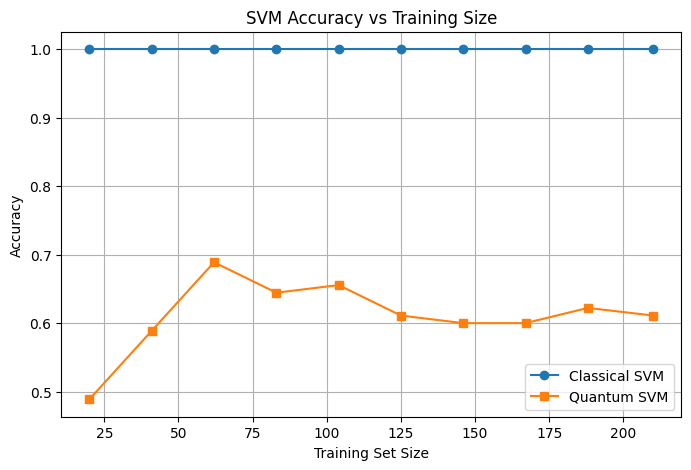

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, classical_metrics["accuracy"], marker="o", label="Classical SVM")
plt.plot(train_sizes, quantum_metrics["accuracy"], marker="s", label="Quantum SVM")

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("SVM Accuracy vs Training Size")
plt.legend()
plt.grid(True)
plt.show()


### Cell 8 — Final Comparison Table

In [8]:
results = pd.DataFrame({
    "Model": ["Classical SVM", "Quantum SVM"],
    "Final Accuracy": [
        classical_metrics["accuracy"][-1],
        quantum_metrics["accuracy"][-1]
    ]
})

results


,Model,Final Accuracy
0,Classical SVM,1.000000
1,Quantum SVM,0.611111


**Paper framing:**
“Quantum kernels implicitly map data to high-dimensional Hilbert spaces.”